In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2
import os
import sys
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import umap
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# INFO
Before running this notebook, you need to generate data in an acceptable format for running DCA, and then run it 
from the command line using `dca matrix.csv result_dir/`. 

Then, set the dca_results_dir variable below to point to result_dir as created from the above command 

In [2]:
# read in results of DCA
#dca_results_dir = "dca_results_random30k"
dca_results_dir = "dca_retina_ct_2"
dca_results = pd.read_csv(os.path.join(dca_results_dir, "reduced.tsv"), sep="\t", header=None, index_col=0)
print(dca_results.shape)

(15540, 32)


In [3]:
dca_results.head()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,,,,,,,,,,,,,,,,,,,,,
0,-2.279622,-3.569134,0.953763,-2.238889,7.484837,1.918864,-0.939237,1.953660,0.743326,2.319976,...,0.312672,0.865750,4.783923,-3.138721,-1.629450,-0.720040,-2.893276,-1.916676,-1.831034,-1.492994
1,-2.873245,-2.954705,1.822902,-2.340160,7.377391,1.841643,-1.334756,1.277103,0.340042,2.250835,...,0.314371,1.123329,4.727243,-2.984837,-1.284343,-1.315737,-3.083980,-1.936447,-2.095136,-1.796218
2,-2.116968,-3.195355,1.177893,-1.804084,6.397964,1.470806,-0.762743,1.179564,0.107617,2.331190,...,0.608428,1.156739,4.160211,-2.619189,-1.173580,-0.798913,-2.677669,-1.493415,-1.433233,-1.379889
3,-2.896487,-3.560423,1.893590,-2.161044,8.855577,2.393528,-1.439330,1.840438,0.526023,2.695086,...,0.958937,0.905376,5.289253,-4.039077,-2.036659,-1.262073,-2.728431,-2.322397,-2.081763,-1.738638
4,-2.733045,-3.792399,2.082664,-2.643939,8.784364,2.804672,-2.147891,2.170925,-0.368318,2.569971,...,0.574646,1.767145,5.236625,-3.662727,-2.015984,-1.293390,-2.929261,-1.669601,-1.628297,-2.403709


In [4]:
# read in label info 

#label_info = pd.read_csv("subsampled_CLUESImmVar_nonorm.label_info.csv", sep=",", header=0, index_col=0)
label_info = pd.read_csv("pbmc_eq_ct_batch_labels.csv", sep=",", header=0)
print(label_info.shape)

(8016, 2)


In [5]:
label_info.head()

,batch_cov,ct_cov
0,0,CD4 T cells
1,0,CD4 T cells
2,0,CD4 T cells
3,0,CD4 T cells
4,0,CD4 T cells


In [6]:
# join data 
dca_results_with_labels = dca_results.join(label_info, how='inner')
print(dca_results_with_labels.shape)

(8016, 34)


In [7]:
dca_results_with_labels.head()

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,batch_cov,ct_cov
0,-2.279622,-3.569134,0.953763,-2.238889,7.484837,1.918864,-0.939237,1.953660,0.743326,2.319976,...,4.783923,-3.138721,-1.629450,-0.720040,-2.893276,-1.916676,-1.831034,-1.492994,0,CD4 T cells
1,-2.873245,-2.954705,1.822902,-2.340160,7.377391,1.841643,-1.334756,1.277103,0.340042,2.250835,...,4.727243,-2.984837,-1.284343,-1.315737,-3.083980,-1.936447,-2.095136,-1.796218,0,CD4 T cells
2,-2.116968,-3.195355,1.177893,-1.804084,6.397964,1.470806,-0.762743,1.179564,0.107617,2.331190,...,4.160211,-2.619189,-1.173580,-0.798913,-2.677669,-1.493415,-1.433233,-1.379889,0,CD4 T cells
3,-2.896487,-3.560423,1.893590,-2.161044,8.855577,2.393528,-1.439330,1.840438,0.526023,2.695086,...,5.289253,-4.039077,-2.036659,-1.262073,-2.728431,-2.322397,-2.081763,-1.738638,0,CD4 T cells
4,-2.733045,-3.792399,2.082664,-2.643939,8.784364,2.804672,-2.147891,2.170925,-0.368318,2.569971,...,5.236625,-3.662727,-2.015984,-1.293390,-2.929261,-1.669601,-1.628297,-2.403709,0,CD4 T cells


In [8]:
batch_labels = pd.Categorical(dca_results_with_labels["batch_cov"]).codes
cell_type_labels = pd.Categorical(dca_results_with_labels["ct_cov"]).codes

In [9]:
dca_results_without_labels = dca_results_with_labels.drop(["batch_cov", "ct_cov"], axis=1)

In [10]:
np.sum(batch_labels)

4008

# plot first PCs

In [11]:
pca_loadings = PCA(n_components=2).fit_transform(dca_results_without_labels)
print(pca_loadings.shape)

(8016, 2)


No handles with labels found to put in legend.


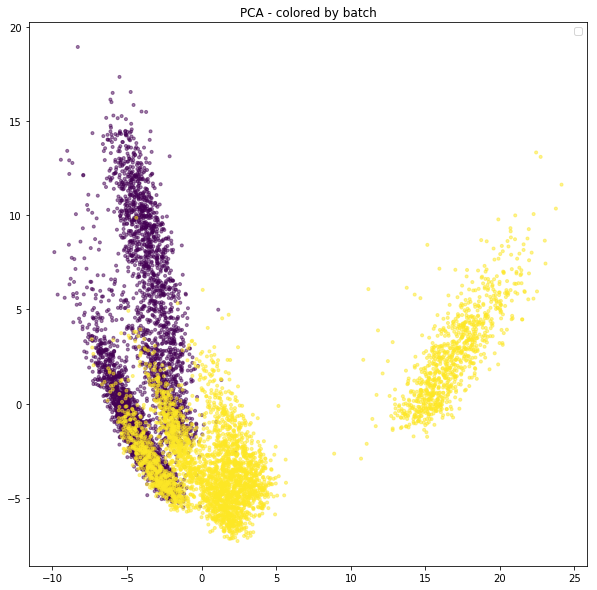

In [12]:
plt.figure(figsize=(10,10))
plt.title("PCA - colored by batch")
# plt.scatter(pca_X[:,0], pca_X[:,1], marker='.')
# plt.scatter(pca_Y[:,0], pca_Y[:,1], marker='.', alpha=0.5)
plt.scatter(pca_loadings[:,0], pca_loadings[:,1], marker='.', alpha=0.5, c=batch_labels)
plt.legend()
plt.show()

No handles with labels found to put in legend.


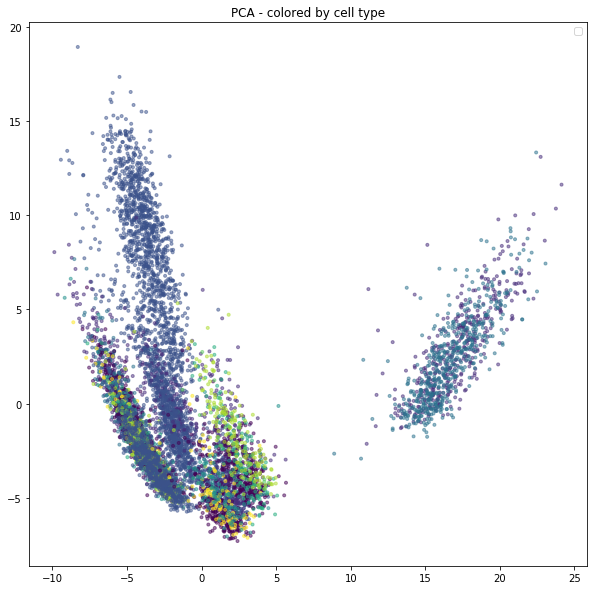

In [13]:
plt.figure(figsize=(10,10))
plt.title("PCA - colored by cell type")
# plt.scatter(pca_X[:,0], pca_X[:,1], marker='.')
# plt.scatter(pca_Y[:,0], pca_Y[:,1], marker='.', alpha=0.5)
plt.scatter(pca_loadings[:,0], pca_loadings[:,1], marker='.', alpha=0.5, c=cell_type_labels)
plt.legend()
plt.show()

# plot UMAP projections

In [14]:
merged_umap = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(dca_results_without_labels)
print(merged_umap.shape)

(8016, 2)


No handles with labels found to put in legend.


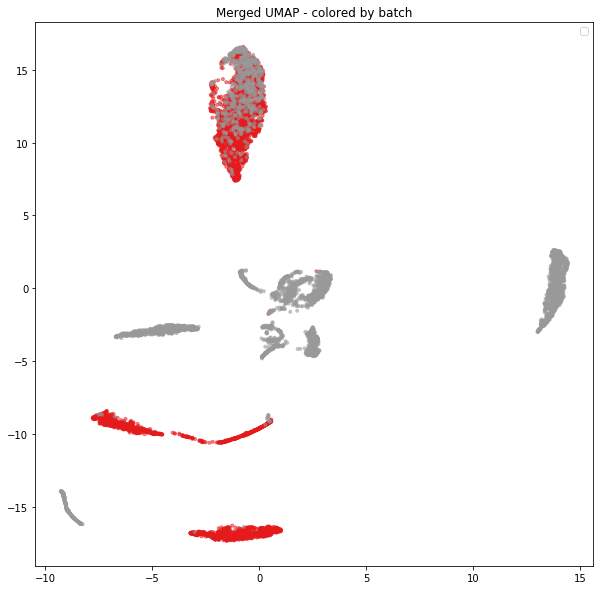

In [15]:
plt.figure(figsize=(10,10))
plt.title("Merged UMAP - colored by batch")

plt.scatter(merged_umap[:,0], merged_umap[:, 1], marker=".", alpha=0.5, c=batch_labels, cmap=matplotlib.cm.Set1)
plt.legend()
# plt.scatter(merged_umap[0:X.shape[1], 0], merged_umap[0:X.shape[1], 1], marker='.', alpha=0.5)
# plt.scatter(merged_umap[Y.shape[1]:, 0], merged_umap[Y.shape[1]:, 1], marker='.', alpha=0.5)
plt.show()

No handles with labels found to put in legend.


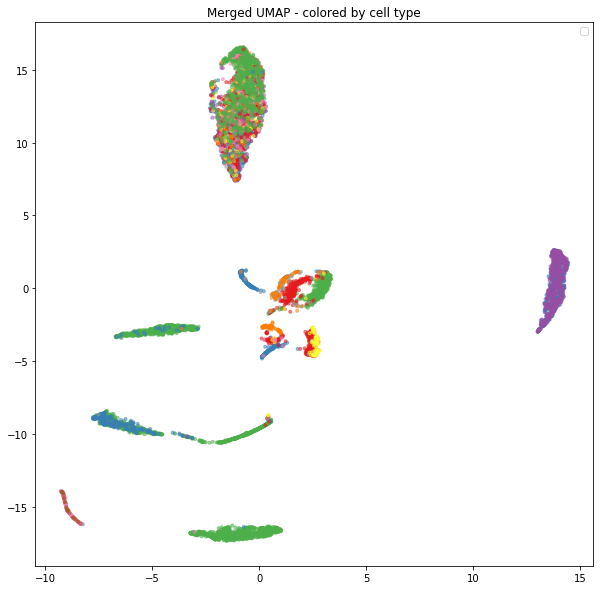

In [16]:
plt.figure(figsize=(10,10))
plt.title("Merged UMAP - colored by cell type")

plt.scatter(merged_umap[:,0], merged_umap[:, 1], marker=".", alpha=0.5, c=cell_type_labels, cmap=matplotlib.cm.Set1)
plt.legend()
# plt.scatter(merged_umap[0:X.shape[1], 0], merged_umap[0:X.shape[1], 1], marker='.', alpha=0.5)
# plt.scatter(merged_umap[Y.shape[1]:, 0], merged_umap[Y.shape[1]:, 1], marker='.', alpha=0.5)
plt.show()

In [17]:
# calculate mean Silhouette coefficient of all samples using batch labels (value should be close to 0)
sil_score = silhouette_score(dca_results_without_labels, batch_labels)
print("Silhouette score with batch labels: {}".format(sil_score))

Silhouette score with batch labels: 0.21076793098071472


In [18]:
# calculate mean Silhouette coefficient of all samples using cell type labels (value should be close to 1)
sil_score = silhouette_score(dca_results_without_labels, cell_type_labels)
print("Silhouette score with cell type labels: {}".format(sil_score))

Silhouette score with cell type labels: -0.06604337693421185


In [19]:
# k0 = int(np.floor(np.mean(pd.DataFrame(batch_labels).iloc[:,0].value_counts())))
# print("k0: ", k0)
# knn = NearestNeighbors(n_neighbors=k0, algorithm='ball_tree', n_jobs=-1).fit(dca_results_without_labels)

In [20]:
#knn = pd.DataFrame(knn.kneighbors()[0])

/Users/bhizzle/code/anaconda2/envs/sc/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Users/bhizzle/code/anaconda2/envs/sc/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: FNN

  warnings.warn(x, RRuntimeWarning)


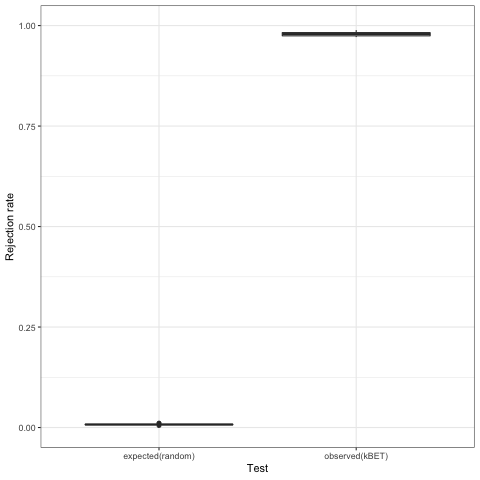

In [21]:
%%R -i dca_results_without_labels -i batch_labels -o batch_estimate
library(kBET)
require('FNN')

# data: a matrix (rows: samples, columns: features (genes))
#k0=floor(mean(table(batch_labels))) #neighbourhood size: mean batch size 
#knn <- get.knn(dca_results_without_labels, k=k0, algorithm = 'cover_tree')

#now run kBET with pre-defined nearest neighbours.
batch_estimate <- kBET(dca_results_without_labels, batch_labels, do.pca=FALSE, n_repeat=20)

In [22]:
print(batch_estimate)

$summary
      kBET.expected kBET.observed kBET.signif
mean    0.007647548     0.9792394           0
2.5%    0.005361596     0.9719140           0
50%     0.007481297     0.9788030           0
97.5%   0.010806318     0.9887781           0

$results
     tested kBET.pvalue.test kBET.pvalue.null
1         1     0.000000e+00       0.67692157
2         1     0.000000e+00       0.83237181
3         1     0.000000e+00       0.67590028
4         1     0.000000e+00       0.79662284
5         1     0.000000e+00       0.67164617
6         1     0.000000e+00       0.68566865
7         1     0.000000e+00       0.67988573
8         1     0.000000e+00       0.61334068
9         1     0.000000e+00       0.79279867
10        1     0.000000e+00       0.68157783
11        1     0.000000e+00       0.68916199
12        1     0.000000e+00       0.69911924
13        1     0.000000e+00       0.71318713
14        1     0.000000e+00       0.86015466
15        1     0.000000e+00       0.64212075
16        1    